In [129]:
########################################
#             PATH SETUP
########################################

import sys
import glob
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from pathlib import Path
from collections.abc import Iterable
from typing import Dict

import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [130]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n



def _node_order(scopes: list[str]) -> list[str]:
    """Ordina alfabeticamente i NODE_* (A,B,C,...) per avere pannelli stabili."""
    nodes = [s for s in scopes if isinstance(s, str) and s.startswith("NODE_")]
    return sorted(nodes, key=lambda s: s.replace("NODE_", ""))


def _node_label(scope: str) -> str:
    """Etichetta leggibile per un NODE_*."""
    name = scope.replace("NODE_", "")
    mapping = {"A":"Server A", "B":"Server B", "C":"Server C", "P":"Server P"}
    return mapping.get(name, f"Server {name}")


plt.rcParams.update({
    "figure.figsize": (7.4, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "left",
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "legend.frameon": False,
    "lines.linewidth": 2.0,
    "lines.markersize": 5.5,
})
PALETTE = {
    "THEORY": "#1f77b4",   # blu per teoria
    "SIM":    "#ff7f0e",   # arancio per simulazione
    "A":      "#2ca02c",   # verde
    "B":      "#d62728",   # rosso
    "C":      "#000000",   # rosso
    "P":      "#9467bd",   # viola
}

MARKER_POOL = ["o", "s", "^", "D", "v", "P", "X", "*"]  # aggiungi se vuoi
def marker_style_for(index: int, color: str):
    m = MARKER_POOL[index % len(MARKER_POOL)]
    # ogni “giro” della lista alterna pieno/vuoto per aumentare la varietà
    hollow = (index // len(MARKER_POOL)) % 2 == 1
    return dict(
        marker=m, markersize=6.5,
        markerfacecolor=("white" if hollow else color),
        markeredgecolor=color, markeredgewidth=1.8,
    )



BASE_DIR = ".output_simulation"

# configurazione all'inizio del notebook
OBJ = 1   # scegli 1, 2 o 3

# costruisco dinamicamente il nome del file
config_file = f"obj{OBJ}.json"

TITLE_PREFIX = f"OBJ{OBJ}"



In [131]:

# ================== DISCOVERY / LOAD ==================

def find_csv_for_config(config_path: str, base_dir=BASE_DIR, target="results") -> List[str]:
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"{target}_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))




def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df


# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

# ================== PLOTTING (Torkin-like) ==================


In [132]:
conv_files=find_csv_for_config(config_file,target="conv")


In [133]:
# === Utilities mancanti per plot_system_rt ===
import numpy as np
import pandas as pd
import math

def estimate_demands_from_df(df_all: pd.DataFrame) -> dict:
    """
    Stima i service demand D_j di ciascun nodo usando l'identità ρ_j = X * D_j.
    - X è il throughput medio OVERALL.
    - Per ogni NODE_* prende la media di 'utilization' e fa D_j = rho_j / X.
    Ritorna un dict con chiavi 'D_<NODE>' e campi di servizio:
      - 'bottleneck': la chiave del nodo col D_j massimo (es. 'D_B')
      - 'X_sat'    : 1 / max(D_j) (asintoto verticale teorico)
    """
    if df_all.empty:
        raise ValueError("df_all è vuoto")

    df_overall = df_all[df_all["scope"] == "OVERALL"]
    df_nodes   = df_all[df_all["scope"].astype(str).str.startswith("NODE_")]

    if "throughput" not in df_overall.columns:
        raise KeyError("Manca la colonna 'throughput' in OVERALL")

    X = float(df_overall["throughput"].mean())
    if X <= 0 or not math.isfinite(X):
        raise ValueError(f"Throughput OVERALL non valido: {X}")

    out = {}
    for scope, grp in df_nodes.groupby("scope"):
        if "utilization" not in grp.columns or grp["utilization"].dropna().empty:
            continue
        rho = float(grp["utilization"].mean())
        node_name = scope.replace("NODE_", "")  # es. "A", "B", "P"
        out[f"D_{node_name}"] = rho / X

    if not out:
        raise ValueError("Non ho trovato NODE_* con 'utilization' per stimare i demand")

    # individua il bottleneck e calcola X_sat
    bneck_key = max(out, key=out.get)  # 'D_<NODE>' col valore massimo
    Dmax = out[bneck_key]
    out["bottleneck"] = bneck_key
    out["X_sat"] = 1.0 / Dmax if Dmax > 0 else float("inf")
    return out


def aggregate_sim_overall(df_overall: pd.DataFrame):
    """
    Aggrega OVERALL.mean_response_time rispetto ad un asse X scelto dinamicamente
    (usa choose_overall_x definita nelle tue utilities) e calcola mean ± CI95%.
    Ritorna: (df_agg, xcol, xlabel)
    """
    if "mean_response_time" not in df_overall.columns:
        raise KeyError("Manca 'mean_response_time' in OVERALL")

    xcol, xlabel = choose_overall_x(df_overall)  # già definita nel notebook
    g = agg_ci(df_overall, xcol, "mean_response_time")  # usa mean/ci_lo/ci_hi
    return g, xcol, xlabel


def theoretical_R(x, demands):
    x = np.asarray(x, dtype=float)
    Ds = [v for k,v in demands.items() if isinstance(k,str) and k.startswith("D_")]
    R = np.zeros_like(x, dtype=float)
    for Dj in Ds:
        R += Dj / (1.0 - x * Dj)
    X_sat = 1.0 / max(Ds)
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)
    valid = (x <= X_sat - eps)
    R = np.where(valid & np.isfinite(R) & (R > 0), R, np.nan)
    return R


In [134]:

###############

def per_job_covariance(base_dir=BASE_DIR):
    files = glob.glob(os.path.join(base_dir, "per_job_times*.csv"))
    if not files:
        print("Nessun per_job_times*.csv")
        return

    df = pd.concat([pd.read_csv(p) for p in files], ignore_index=True)

    # prendi dinamicamente tutte le colonne T_*
    cols = [c for c in df.columns if c.startswith("T_")]
    if len(cols) < 2:
        print("per_job_times ha meno di 2 colonne T_*")
        return

    # calcola covariance e correlation solo sulle colonne trovate
    cov = df[cols].cov()
    corr = df[cols].corr()

    print("Colonne trovate:", cols)
    print("\nCovariance matrix:\n", cov.round(5))
    print("\nCorrelation matrix:\n", corr.round(4))

# esempio di chiamata
per_job_covariance()



Colonne trovate: ['T_A', 'T_B', 'T_P', 'T_total']

Covariance matrix:
               T_A         T_B      T_P     T_total
T_A      18.09430     4.72482  0.18465    23.00377
T_B       4.72482  1216.63240  0.35229  1221.70950
T_P       0.18465     0.35229  0.95891     1.49585
T_total  23.00377  1221.70950  1.49585  1246.20912

Correlation matrix:
             T_A     T_B     T_P  T_total
T_A      1.0000  0.0318  0.0443   0.1532
T_B      0.0318  1.0000  0.0103   0.9922
T_P      0.0443  0.0103  1.0000   0.0433
T_total  0.1532  0.9922  0.0433   1.0000


In [135]:
# Sanity check
files = find_csv_for_config(config_file, base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

CSV trovati: 10
 - .output_simulation\results_obj1_run000_seed314159265_20250821_175645.csv
 - .output_simulation\results_obj1_run000_seed314159265_20250822_103414.csv
 - .output_simulation\results_obj1_run001_seed271828183_20250821_175649.csv
 - .output_simulation\results_obj1_run001_seed271828183_20250822_103419.csv
 - .output_simulation\results_obj1_run002_seed141421357_20250821_175654.csv
 - .output_simulation\results_obj1_run002_seed141421357_20250822_103424.csv
 - .output_simulation\results_obj1_run003_seed1732584193_20250821_175658.csv
 - .output_simulation\results_obj1_run003_seed1732584193_20250822_103428.csv
 - .output_simulation\results_obj1_run004_seed123456789_20250821_175702.csv
 - .output_simulation\results_obj1_run004_seed123456789_20250822_103433.csv


In [136]:
def plot_system_rt(df_all: pd.DataFrame,
                   *,
                   width: float = 9.5,
                   height: float = 4.8,
                   dpi: int = 130,
                   show_theory: bool = True,
                   zoom_range: tuple[float, float] | None = None,
                   x_overview_cap: float = 1.6,    # limite massimo estendibile per l’asse X dell’overview
                   right_pad_ratio: float = 0.06,  # padding percentuale a destra dell’overview
                   y_cap_overview: float | None = None,  # max Y overview (None = auto)
                   y_cap_zoom: float | None = None,      # max Y zoom (None = auto)
                   percentile_cap: float = 99.0          # percentile per auto-cap
                   ):
    """
    SYSTEM: simulazione (media ± CI) + curva teorica opzionale.
    - Se zoom_range=(x0,x1): due pannelli con assi X INDIPENDENTI.
      Sopra: overview estesa oltre i dati + riquadro che indica la zona di zoom.
      Sotto: zoom su [x0,x1].
    - Mostra l’asintoto verticale a X_sat.
    - Normalizza la scala Y (auto o manuale) ed evita valori negativi/non fisici.
    """

    # --- 1) stima demand + X_sat (asintoto) ---
    D = estimate_demands_from_df(df_all)
    X_sat = float(D["X_sat"])
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)

    # --- 2) OVERALL aggregato (mean ± CI) ---
    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time.")
        return
    agg, xcol, xlabel = aggregate_sim_overall(df_overall)

    # --- helper: media + CI (barre spesse) ---
    def draw_mean_ci(ax, agg_df, *, color, label_mean="Simulazione (mean)"):
        x  = agg_df[xcol].to_numpy()
        mu = agg_df["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(agg_df["ci_lo"]), agg_df["ci_lo"], mu)
        hi = np.where(np.isfinite(agg_df["ci_hi"]), agg_df["ci_hi"], mu)
        yerr = np.vstack([mu - lo, hi - mu])
        ax.plot(x, mu, "o-", color=color, linewidth=2.3, zorder=3, label=label_mean)
        ax.errorbar(x, mu, yerr=yerr, fmt="none", ecolor="black",
                    elinewidth=2.0, capsize=5, zorder=4, label="CI 95%")
        return x, mu, lo, hi

    # --- 3) range X dei dati + estensione dinamica per l’overview ---
    xmin_data, xmax_data = float(np.nanmin(agg[xcol])), float(np.nanmax(agg[xcol]))
    x_overview_min = xmin_data if zoom_range is None else min(xmin_data, zoom_range[0])

    # includi fine dati, fine zoom e 1.02*X_sat (se ci sta), poi pad destro
    x_target_max = max(xmax_data,
                       (zoom_range[1] if zoom_range else xmax_data),
                       X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- 4) curve teoriche su griglie adeguate + mascheratura fisica ---
    def theory_masked(xgrid: np.ndarray) -> np.ndarray:
        """Teoria M/M/1 in serie, mascherata a destra di X_sat e per valori non fisici."""
        y = theoretical_R(xgrid, D) if show_theory else None
        if y is None:
            return None
        mask = (xgrid <= X_sat - eps) & np.isfinite(y) & (y > 0)
        return np.where(mask, y, np.nan)

    grid_over = np.linspace(max(1e-6, x_overview_min*0.98), x_overview_max, 1500)
    R_over = theory_masked(grid_over)

    # === CASO A: grafico singolo (solo overview estesa) ===
    if zoom_range is None:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)

        # teoria
        if show_theory:
            ax.plot(grid_over, R_over, color=PALETTE["THEORY"],
                    label="Teoria (M/M/1 in serie)", zorder=0)

        # simulazione
        _, mu, lo, hi = draw_mean_ci(ax, agg, color=PALETTE["SIM"])

        # asintoto a X_sat se rientra nell’overview
        if x_overview_min <= X_sat <= x_overview_max:
            ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.85,
                       linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

        # normalizzazione Y (auto-cap se non fornito)
        if y_cap_overview is None:
            pool = [mu]
            if R_over is not None:
                pool.append(R_over)
            # includi anche gli estremi delle CI per non tagliarle
            pool.extend([lo, hi])
            vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None])
            if vals.size:
                cap = np.nanpercentile(vals, percentile_cap) * 1.05
                y_cap_overview = float(cap) if np.isfinite(cap) else None
        ax.set_ylim(bottom=0, top=y_cap_overview)

        ax.set_xlim(x_overview_min, x_overview_max)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Mean Response Time (s)")
        ax.set_title(f"{TITLE_PREFIX} — SYSTEM: teoria vs simulazione")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()
        return

    # === CASO B: overview + zoom con assi X indipendenti ===
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(width, height * 1.35), dpi=dpi,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    # --- OVERVIEW ---
    if show_theory:
        ax1.plot(grid_over, R_over, color=PALETTE["THEORY"],
                 label="Teoria (M/M/1 in serie)", zorder=0)
    _, mu_o, lo_o, hi_o = draw_mean_ci(ax1, agg, color=PALETTE["SIM"])

    # asintoto nell’overview
    if x_overview_min <= X_sat <= x_overview_max:
        ax1.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

    # riquadro della zona di zoom
    import matplotlib.patches as patches
    y0, y1 = ax1.get_ylim()
    rect = patches.Rectangle(
        (zoom_range[0], y0),
        zoom_range[1] - zoom_range[0],
        (y1 - y0)*0.06,
        facecolor="none", edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6
    )
    ax1.add_patch(rect)

    ax1.set_xlim(x_overview_min, x_overview_max)
    ax1.set_ylabel("Mean Response Time (s)")
    ax1.set_title(f"{TITLE_PREFIX} — SYSTEM: overview + zoom")
    ax1.grid(True, linestyle="--", alpha=0.35)
    ax1.legend(loc="upper left")

    # --- ZOOM ---
    grid_z = np.linspace(zoom_range[0], zoom_range[1], 1200)
    R_zoom = theory_masked(grid_z)
    if show_theory:
        ax2.plot(grid_z, R_zoom, color=PALETTE["THEORY"], linewidth=2.0, alpha=0.85)
    _, mu_z, lo_z, hi_z = draw_mean_ci(ax2, agg, color=PALETTE["SIM"])

    # asintoto nello zoom (se cade nel range)
    if zoom_range[0] <= X_sat <= zoom_range[1]:
        ax2.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0)

    ax2.set_xlim(*zoom_range)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel("Time (s)")
    ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax2.grid(True, linestyle="--", alpha=0.35)

    # --- Normalizzazione Y (auto se non specificata) ---
    if y_cap_overview is None:
        pool_o = [mu_o, lo_o, hi_o]
        if R_over is not None: pool_o.append(R_over)
        vals_o = np.hstack([p[np.isfinite(p)] for p in pool_o if p is not None])
        if vals_o.size:
            cap_o = np.nanpercentile(vals_o, percentile_cap) * 1.05
            y_cap_overview = float(cap_o) if np.isfinite(cap_o) else None

    if y_cap_zoom is None:
        pool_z = [mu_z, lo_z, hi_z]
        if R_zoom is not None: pool_z.append(R_zoom)
        vals_z = np.hstack([p[np.isfinite(p)] for p in pool_z if p is not None])
        if vals_z.size:
            cap_z = np.nanpercentile(vals_z, percentile_cap) * 1.05
            y_cap_zoom = float(cap_z) if np.isfinite(cap_z) else None

    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    # tick X indipendenti
    from matplotlib.ticker import MaxNLocator
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=8))

    plt.tight_layout()
    plt.show()


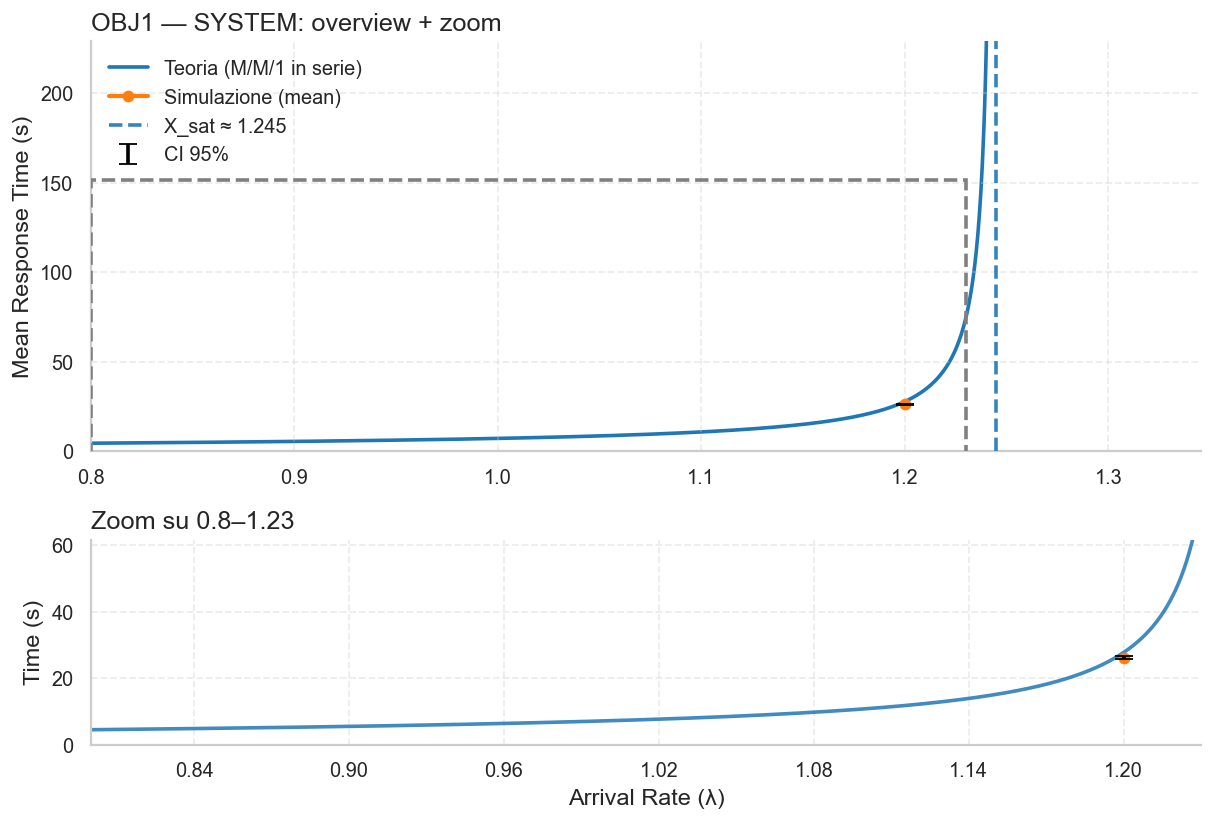

In [137]:
# SYSTEM con zoom sulla coda verso saturazione
df_all = load_runs(files)

plot_system_rt(df_all, zoom_range=(0.8, 1.23)) #usare questo per obj1 e 2 
#plot_system_rt(df_all, zoom_range=(1.21, 1.43)) #usare questo per obj3



In [138]:
def plot_nodes_rt(df_all: pd.DataFrame,
                  *,
                  nodes: tuple[str, ...] | None = None,
                  width: float = 9.5,
                  height: float = 5.2,
                  dpi: int = 130,
                  show_theory: bool = True,
                  zoom_range: tuple[float, float] | None = (0.8, 1.21),
                  x_overview_cap: float = 1.6,
                  right_pad_ratio: float = 0.06,
                  y_cap_overview: float | None = None,
                  y_cap_zoom: float | None = None,
                  percentile_cap: float = 99.0,
                  per_job_nodes: set[str] = set(),      # <— per-visita di default (coerente col CSV)
                  zoom_box_frac: float = 1):         # altezza del box grigio nell’overview (4%)
    """
    NODES: overview = SOLO mean; zoom = mean ± CI.
    Teoria per nodo j:
      - se j in per_job_nodes:   R_j = D_j / (1 - λ D_j)        (tempo totale al nodo per job)
      - altrimenti (default):    R_j = S_j / (1 - λ D_j)        (tempo per-visita) con D_j = V_j S_j
    La teoria è mascherata a destra di X_sat e per valori non fisici.
    """

    # --- dati nodo ---
    df_nodes = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "mean_response_time" not in df_nodes.columns:
        print("Mancano dati NODE_*/mean_response_time.")
        return

    scopes_all = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if nodes is not None:
        wanted = {f"NODE_{n}" for n in nodes}
        scopes = [s for s in scopes_all if s in wanted]
    else:
        scopes = scopes_all
    if not scopes:
        print("Nessun nodo da plottare dopo il filtro.")
        return

    # --- asse X + demands ---
    xcol, xlabel = choose_node_x(df_nodes)
    Ddict = estimate_demands_from_df(df_all)           # deve dare almeno D_* e X_sat
    X_sat = float(Ddict["X_sat"])
    eps   = max(1e-9, 5*np.finfo(float).eps * X_sat)

    # fallback visite se mancanti
    VISITS_DEFAULT = {"A": 3.0, "B": 1.0, "P": 1.0}

    # --- aggregazioni ---
    agg_by_node = {
        scope: agg_ci(df_nodes[df_nodes["scope"] == scope], xcol, "mean_response_time")
        for scope in scopes
    }

    # --- range X overview (come SYSTEM) ---
    x_all = pd.concat([agg_by_node[s][xcol] for s in scopes], ignore_index=True)
    x_min, x_max = float(np.nanmin(x_all)), float(np.nanmax(x_all))
    x_overview_min = x_min if zoom_range is None else min(x_min, zoom_range[0])
    x_target_max = max(x_max, (zoom_range[1] if zoom_range else x_max), X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- helper plot ---
    def draw_mean(ax, g, *, color, label):
        x = g[xcol].to_numpy()
        m = g["mean"].to_numpy(dtype=float)
        ax.plot(x, m, "o-", linewidth=2.0, color=color, label=label)
        return m

    def draw_mean_ci(ax, g, *, color, label):
        x  = g[xcol].to_numpy()
        m  = g["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(g["ci_lo"]), g["ci_lo"], m)
        hi = np.where(np.isfinite(g["ci_hi"]), g["ci_hi"], m)
        ax.errorbar(x, m, yerr=[m - lo, hi - m], fmt="o-", color=color,
                    ecolor=color, elinewidth=2.0, capsize=5, alpha=0.9, linewidth=2.0,
                    label=label)
        return m, lo, hi

    def r_theory_node(node_name: str, xgrid: np.ndarray) -> np.ndarray:
        Dj = float(Ddict.get(f"D_{node_name}", np.nan))  # D = V*S
        Vj = float(Ddict.get(f"V_{node_name}", VISITS_DEFAULT.get(node_name, 1.0)))
        Sj_from = Ddict.get(f"S_{node_name}", None)
        if Sj_from is not None and np.isfinite(Sj_from) and Sj_from > 0:
            Sj = float(Sj_from)
        else:
            Sj = Dj / Vj if np.isfinite(Dj) and Dj > 0 and np.isfinite(Vj) and Vj > 0 else np.nan
        if not (np.isfinite(Dj) and Dj > 0 and np.isfinite(Sj) and Sj > 0):
            return np.full_like(xgrid, np.nan, dtype=float)

        y = (Dj if node_name in per_job_nodes else Sj) / (1.0 - xgrid * Dj)
        mask = (xgrid <= X_sat - eps) & np.isfinite(y) & (y > 0)
        return np.where(mask, y, np.nan)

    def auto_cap(pool):
        vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None] or [])
        if vals.size:
            cap = np.nanpercentile(vals, percentile_cap) * 1.05
            return float(cap) if np.isfinite(cap) else None
        return None

    # --- figure: overview + zoom ---
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(width, height * 1.35), dpi=dpi,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    grid_over = np.linspace(max(1e-6, x_overview_min * 0.98), x_overview_max, 2000)
    grid_z    = np.linspace(zoom_range[0], zoom_range[1], 1200)

    pool_o, pool_z = [], []

    for scope in scopes:
        node  = scope.replace("NODE_", "")
        label = _node_label(scope)
        col   = PALETTE.get(node, "#333333")

        # overview → SOLO mean
        m_o = draw_mean(ax1, agg_by_node[scope], color=col, label=f"{label} (mean)")
        pool_o.append(m_o)

        # zoom → mean ± CI
        m_z, lo_z, hi_z = draw_mean_ci(ax2, agg_by_node[scope], color=col,
                                       label=f"{label} (mean ± CI)")
        pool_z.extend([m_z, lo_z, hi_z])

        # teoria (mascherata)
        if show_theory:
            y_over = r_theory_node(node, grid_over)
            y_zoom = r_theory_node(node, grid_z)
            if np.isfinite(y_over).any():
                ax1.plot(grid_over, y_over, color=col, linestyle="--",
                         linewidth=1.5, alpha=0.9, label=f"{label} theory")
            if np.isfinite(y_zoom).any():
                ax2.plot(grid_z, y_zoom, color=col, linestyle="--",
                         linewidth=1.5, alpha=0.9, label=f"{label} theory")

    # X_sat
    if x_overview_min <= X_sat <= x_overview_max:
        ax1.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label="X_sat")
    if zoom_range[0] <= X_sat <= zoom_range[1]:
        ax2.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label="X_sat")

    # cap Y auto (se non forniti)
    if y_cap_overview is None:
        y_cap_overview = auto_cap(pool_o)
    if y_cap_zoom is None:
        y_cap_zoom = auto_cap(pool_z)

    ax1.set_xlim(x_overview_min, x_overview_max)
    ax2.set_xlim(*zoom_range)
    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    # box grigio “zoom” nell’overview (disegnato DOPO i limiti)
    import matplotlib.patches as patches
    y0, y1 = ax1.get_ylim()
    ax1.add_patch(patches.Rectangle(
        (zoom_range[0], y0),
        zoom_range[1] - zoom_range[0],
        (y1 - y0) * float(zoom_box_frac),
        facecolor="none", edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6
    ))

    # aspetto
    ax1.set_ylabel("Mean Response Time (s)")
    ax2.set_ylabel("Mean Response Time (s)")
    ax1.set_title(f"{TITLE_PREFIX} — NODES: overview + zoom")
    ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax1.grid(True, linestyle="--", alpha=0.35)
    ax2.grid(True, linestyle="--", alpha=0.35)

    # legende (deduplicate per pulizia)
    for ax in (ax1, ax2):
        h, l = ax.get_legend_handles_labels()
        uniq = dict(zip(l, h))
        ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9)

    plt.tight_layout()
    plt.show()


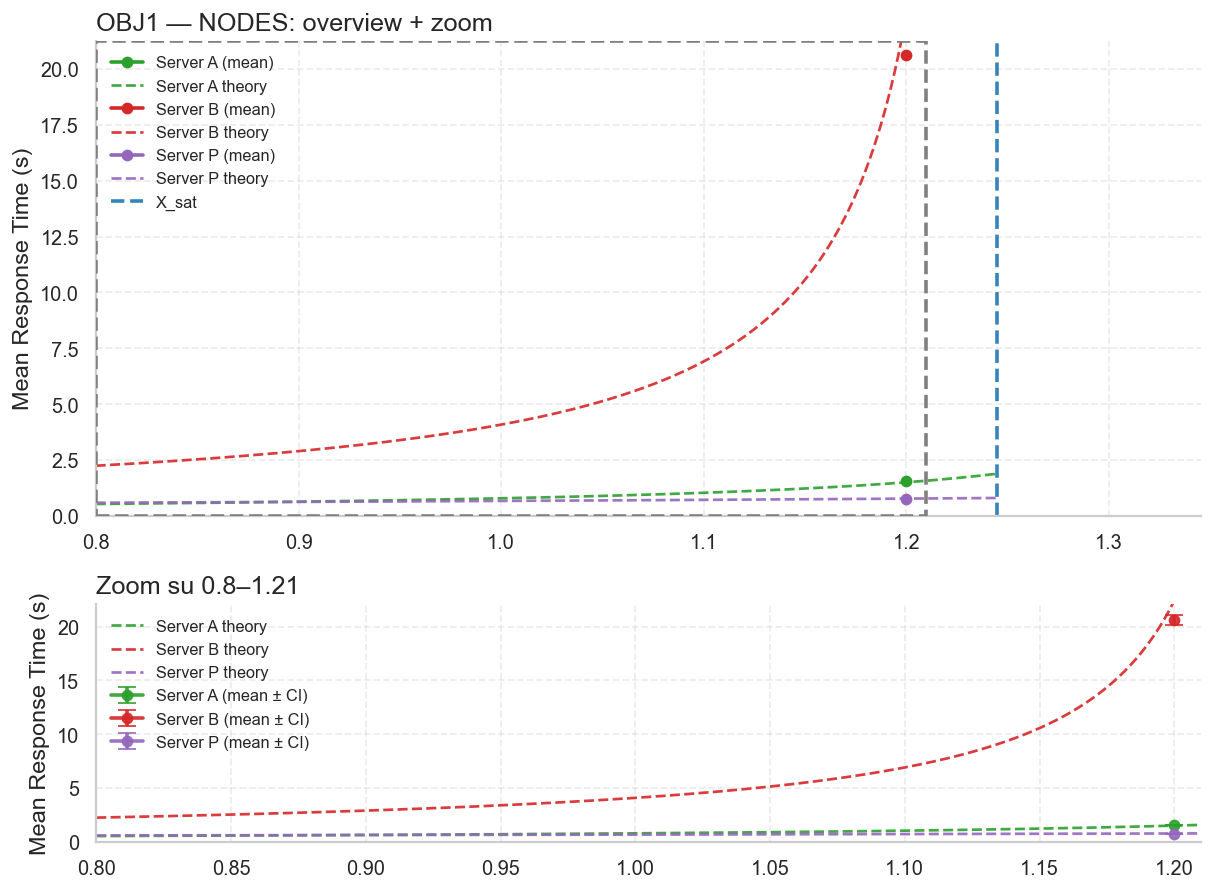

In [139]:
# tutti i nodi rilevati

plot_nodes_rt(df_all, per_job_nodes=set(), zoom_range=(0.8, 1.21)) #usare questo per obj1 e 2
#plot_nodes_rt(df_all, per_job_nodes=set(), zoom_range=(1.21,1.43)) #questo per obj3
# solo un sottoinsieme esplicito (se vuoi)



In [140]:
def plot_system_throughput(df_all: pd.DataFrame,
                           *,
                           width: float = 8.6,
                           height: float = 4.6,
                           dpi: int = 130,
                           show_theory: bool = True,
                           clip_at_Xsat: bool = False,
                           show_residuals: bool = True):
    """
    Confronto throughput complessivo (simulato mean±CI) vs teorico + residui (%).
    Teoria: X(λ) = λ per λ <= X_sat. Se clip_at_Xsat=True, plateau a X_sat oltre.
    """
    # Stime demand + X_sat
    D = estimate_demands_from_df(df_all)
    X_sat = float(D["X_sat"])
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)

    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "throughput" not in df_overall.columns:
        print("Mancano dati OVERALL/throughput."); 
        return

    # preferisci λ come asse; altrimenti replica
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        xcol, xlabel = "arrival_rate", "Arrival Rate (λ)"
    else:
        xcol, xlabel = ("replica", "Replica")

    agg = agg_ci(df_overall, xcol, "throughput")

    # --- Figure (con o senza pannello residui) ---
    if show_residuals and xcol == "arrival_rate" and show_theory:
        fig, (ax, axr) = plt.subplots(
            2, 1, figsize=(width, height*1.15), dpi=dpi,
            gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        axr = None

    # Simulazione (mean ± CI) con marker dinamici
    x  = agg[xcol].to_numpy()
    mu = agg["mean"].to_numpy(dtype=float)
    lo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"], mu)
    hi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"], mu)

    sim_color = PALETTE.get("SIM", "C0")
    ms = marker_style_for(0, sim_color)
    ax.plot(x, mu, linewidth=2.1, color=sim_color, label="Sim (mean)", **ms)
    ax.fill_between(x, lo, hi, alpha=0.18, linewidth=0, color=sim_color, label="CI 95%")

    # Teoria
    y_theory_at_x = None
    if show_theory and xcol == "arrival_rate":
        xgrid = np.linspace(float(np.nanmin(x))*0.98, float(np.nanmax(x))*1.02, 800)
        X_theory = np.where(xgrid <= X_sat - eps, xgrid, (X_sat if clip_at_Xsat else np.nan))
        ax.plot(xgrid, X_theory, color=PALETTE["THEORY"], linewidth=2.0,
                label=("Teoria (plateau)" if clip_at_Xsat else "Teoria"))

        # teoria campionata sugli stessi punti della simulazione (per residui)
        y_theory_at_x = np.interp(x, xgrid, X_theory)

    # X_sat
    if xcol == "arrival_rate":
        ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0,
                   label=f"X_sat ≈ {X_sat:.3f}")

    ax.set_ylabel("Throughput X (req/s)")
    ax.set_title(f"{TITLE_PREFIX} — SYSTEM: Throughput (sim vs teoria)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda deduplicata
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left")

    # --- Residui (%)
    if axr is not None and y_theory_at_x is not None and np.isfinite(y_theory_at_x).any():
        pct_err = 100.0 * (mu - y_theory_at_x) / np.maximum(y_theory_at_x, 1e-12)
        axr.axhline(0.0, color="#666666", linewidth=1.2)
        axr.plot(x, pct_err, "-", color=sim_color, **ms)
        axr.set_ylabel("% err")
        axr.grid(True, linestyle="--", alpha=0.35)
        axr.set_xlabel(xlabel)
    else:
        ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()




In [141]:
def plot_nodes_throughput(df_all: pd.DataFrame,
                          *,
                          nodes: tuple[str, ...] | None = None,
                          width: float = 9.5,
                          height: float = 5.0,
                          dpi: int = 130,
                          show_theory: bool = True,
                          clip_at_Xsat: bool = True,
                          show_residuals: bool = True):
    """
    Confronto throughput per-nodo (simulato mean±CI) vs teorico + residui (%).
    Teoria: X_j(λ) = V_j * X(λ) con X(λ)=λ per λ<=X_sat (e plateau opzionale).
    Marker dinamici per nodo (supporta 4+ nodi).
    """
    df_nodes = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "throughput" not in df_nodes.columns:
        print("Mancano dati NODE_*/throughput."); 
        return

    # nodi dinamici/filtro
    scopes_all = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if nodes is not None:
        wanted = {f"NODE_{n}" for n in nodes}
        scopes = [s for s in scopes_all if s in wanted]
    else:
        scopes = scopes_all
    if not scopes:
        print("Nessun nodo da plottare dopo il filtro."); 
        return

    # Asse X
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        xcol, xlabel = "arrival_rate", "Arrival Rate (λ)"
    else:
        xcol, xlabel = ("replica", "Replica")

    # Stime demand + X_sat e visite
    Ddict = estimate_demands_from_df(df_all)
    X_sat = float(Ddict["X_sat"])
    eps   = max(1e-9, 5*np.finfo(float).eps * X_sat)
    VISITS_DEFAULT = {"A": 3.0, "B": 1.0, "P": 1.0}  # fallback se mancano V_*

    # Aggrego simulazione per nodo
    agg_by_node = {scope: agg_ci(df_nodes[df_nodes["scope"] == scope], xcol, "throughput")
                   for scope in scopes}

    # --- Figure (con o senza residui)
    if show_residuals and xcol == "arrival_rate" and show_theory:
        fig, (ax, axr) = plt.subplots(
            2, 1, figsize=(width, height*1.18), dpi=dpi,
            gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        axr = None

    # Simulazione: una curva per nodo (mean±CI) con marker dinamici
    scope_index = {scope: idx for idx, scope in enumerate(scopes)}
    for scope in scopes:
        node  = scope.replace("NODE_", "")
        label = _node_label(scope)
        col   = PALETTE.get(node, f"C{scope_index[scope] % 10}")
        g = agg_by_node[scope]

        x  = g[xcol].to_numpy()
        mu = g["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(g["ci_lo"]), g["ci_lo"], mu)
        hi = np.where(np.isfinite(g["ci_hi"]), g["ci_hi"], mu)

        ms = marker_style_for(scope_index[scope], col)
        ax.plot(x, mu, linewidth=2.0, color=col, label=f"{label} (sim mean)", **ms)
        ax.fill_between(x, lo, hi, alpha=0.16, linewidth=0, color=col, label=f"{label} CI95%")

    # Teoria per nodo e residui
    if show_theory and xcol == "arrival_rate":
        # griglia comune per la teoria
        x_all = np.unique(np.hstack([agg_by_node[s][xcol].to_numpy() for s in scopes]))
        xgrid = np.linspace(float(np.nanmin(x_all))*0.98, float(np.nanmax(x_all))*1.02, 800)
        X_theory = np.where(xgrid <= X_sat - eps, xgrid, (X_sat if clip_at_Xsat else np.nan))

        for scope in scopes:
            node  = scope.replace("NODE_", "")
            label = _node_label(scope)
            col   = PALETTE.get(node, f"C{scope_index[scope] % 10}")
            Vj = float(Ddict.get(f"V_{node}", VISITS_DEFAULT.get(node, 1.0)))
            yj_grid = Vj * X_theory
            ax.plot(xgrid, yj_grid, linestyle="--", linewidth=1.6, color=col, alpha=0.9,
                    label=f"{label} teoria")

            # residui (%) sugli stessi punti della simulazione
            g = agg_by_node[scope]
            x  = g[xcol].to_numpy()
            mu = g["mean"].to_numpy(dtype=float)
            y_theo_x = Vj * np.interp(x, xgrid, X_theory)
            if axr is not None and np.isfinite(y_theo_x).any():
                ms = marker_style_for(scope_index[scope], col)
                pct_err = 100.0 * (mu - y_theo_x) / np.maximum(y_theo_x, 1e-12)
                axr.plot(x, pct_err, "-", color=col, label=f"{label} %err", **ms)

    # X_sat
    if xcol == "arrival_rate":
        ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0, label="X_sat")

    ax.set_ylabel("Node Throughput X_j (req/s)")
    ax.set_title(f"{TITLE_PREFIX} — NODES: Throughput (sim vs teoria)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda deduplicata
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9, ncol=2)

    if axr is not None:
        axr.axhline(0.0, color="#666666", linewidth=1.2)
        axr.set_ylabel("% err")
        axr.grid(True, linestyle="--", alpha=0.35)
        axr.set_xlabel(xlabel)
    else:
        ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()


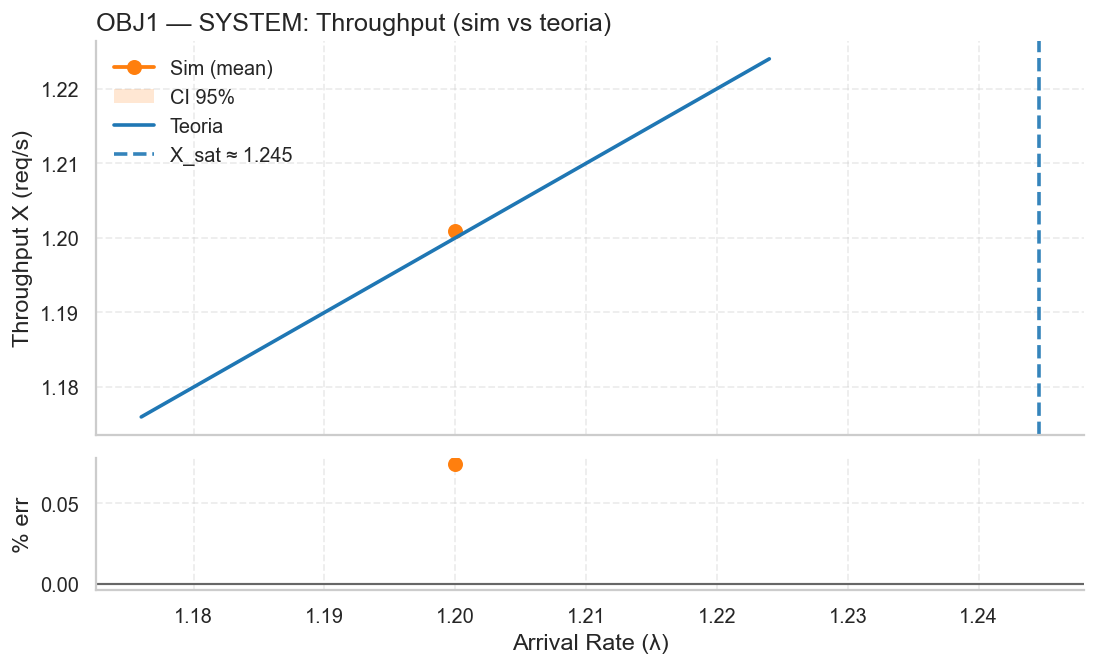

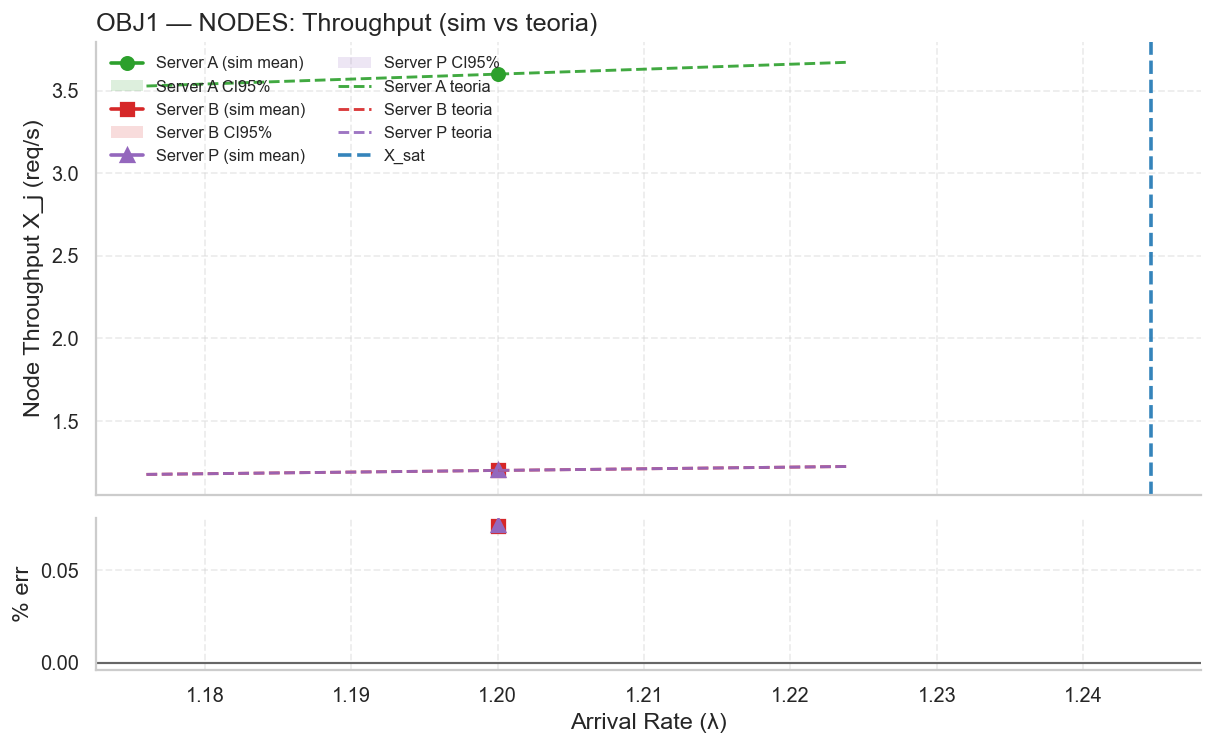

In [142]:
# Confronto throughput complessivo
plot_system_throughput(df_all, clip_at_Xsat=False)

# Confronto throughput per nodo (usa le visite nominali se non hai V_j stimati)
plot_nodes_throughput(df_all, clip_at_Xsat=False)


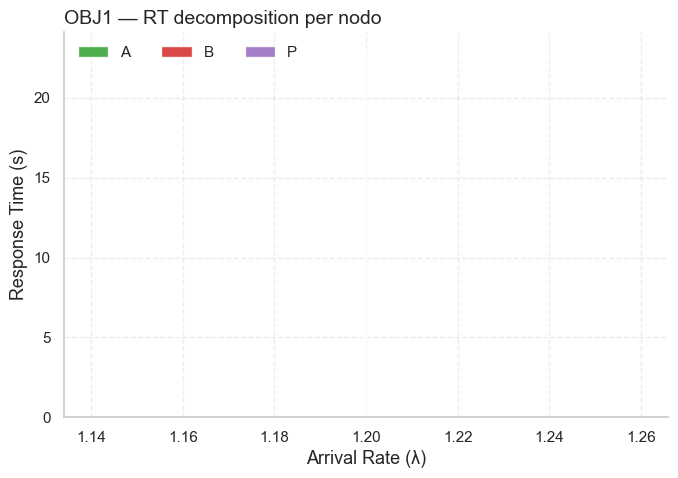

In [143]:
def plot_rt_decomposition(df_all: pd.DataFrame, percent: bool = False):
    """
    Disegna la decomposizione del tempo di risposta per tutti i nodi NODE_* presenti.
    Se percent=True, mostra le percentuali (0–100%) invece dei valori assoluti.
    """
    # filtra righe dei nodi
    dn = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if dn.empty or "mean_response_time" not in dn.columns:
        print("[INFO] Dati insufficienti per RT decomposition.")
        return

    # media per (λ, nodo)
    dn = dn.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)

    # pivot: righe = λ, colonne = NODE_*
    piv = dn.pivot(index="arrival_rate", columns="scope", values="mean_response_time").fillna(0.0)

    # ordina colonne alfabeticamente per nodo (A,B,C,P,...)
    cols = sorted(piv.columns, key=lambda s: s.replace("NODE_", ""))
    piv = piv[cols].sort_index()

    # se percentuale, normalizza per riga
    if percent:
        totals = piv.sum(axis=1).replace(0, np.nan)
        piv = piv.div(totals, axis=0) * 100.0

    # etichette "A","B","C","P",... e colori (se PALETTE è definita)
    labels = [c.replace("NODE_", "") for c in piv.columns]
    colors = []
    for lab in labels:
        try:
            colors.append(PALETTE.get(lab, None))  # usa palette se disponibile
        except NameError:
            colors.append(None)  # fallback: colori default di Matplotlib

    # se nessun colore esplicito, lascia che Matplotlib scelga la palette
    use_colors = None if all(c is None for c in colors) else colors

    fig, ax = plt.subplots(figsize=(7.8, 5.0))
    ax.stackplot(piv.index, *[piv[c].values for c in piv.columns],
                 labels=labels, colors=use_colors, alpha=0.85)
    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Share of Response Time (%)" if percent else "Response Time (s)")
    if percent:
        ax.set_ylim(0, 100)
    ax.set_title(f"{TITLE_PREFIX} — RT decomposition per nodo" + (" (%)" if percent else ""))
    ax.legend(loc="upper left", ncol=min(4, len(labels)))
    ax.grid(True, linestyle="--", alpha=0.35)
    plt.show()
plot_rt_decomposition(df_all)

Sull’asse X hai il tasso di arrivo (λ), cioè quante richieste al secondo entrano nel sistema.

Sull’asse Y hai il tempo medio di risposta complessivo, ma scomposto (empilato) per ciascun nodo.

Le aree colorate mostrano quanto ciascun nodo contribuisce al tempo totale.

Interpretazione della figura:

La parte verde (A) è il tempo medio speso sul server A (front-end). Rimane sempre piccola.

La parte viola (P) è il tempo medio sul provider esterno. È quasi costante e poco rilevante.

La parte rossa (B) è il tempo medio speso sul server B (app + DB). Questa cresce rapidamente con λ e diventa dominante.

In altre parole, la figura ti dice visivamente che:

quando il carico è basso, il tempo totale è distribuito un po’ fra tutti i nodi,

ma già per λ intorno a 0.9–1.0 il server B diventa il collo di bottiglia,

e vicino a λ=1.2 quasi tutto il tempo di risposta è dovuto a B.

È un modo elegante per mostrare chi sta rallentando il sistema: la crescita verticale della parte rossa significa che il collo di bottiglia si concentra lì.

Seeds trovati: [123456789, 141421357, 271828183, 314159265, 1732584193]


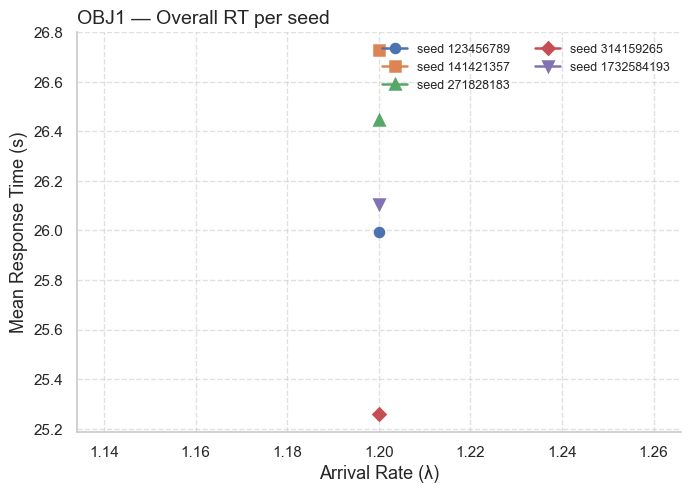

In [144]:

# --- pattern dinamici in base a OBJ e BASE_DIR ---
def make_patterns(obj: int, base_dir: str) -> list[str]:
    """
    Genera una lista di pattern possibili per i CSV per-seed.
    Tenta varianti con/senza 'arrivals' e diverse separazioni per safety.
    """
    base_dir = base_dir.rstrip("/\\")
    patterns = [
        os.path.join(base_dir, f"results_obj{obj}_arrivals_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_arrivals_*seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_*seed*.csv"),
    ]
    return patterns

# regex seed più permissivo: _seed42, -seed=42, _seed-42, ecc.
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def load_arrivals_by_seed(patterns: Iterable[str]) -> pd.DataFrame:
    """
    Carica tutti i CSV che matchano uno QUALSIASI dei pattern,
    aggiunge colonne source/replica/seed. Se non trova nulla, stampa i pattern provati.
    """
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(set(files))  # dedup
    if not files:
        print("[WARN] Nessun CSV trovato per i pattern seguenti:")
        for p in patterns:
            print(" -", p)
        # opzionale: lista rapida della cartella
        base_dirs = sorted(set(os.path.dirname(p) for p in patterns))
        for d in base_dirs:
            try:
                print(f"\nContenuto di {d}:")
                for name in sorted(os.listdir(d)):
                    if name.endswith(".csv"):
                        print("   ", name)
            except FileNotFoundError:
                print(f"(Cartella inesistente: {d})")
        raise FileNotFoundError("Nessun CSV per-seed trovato.")
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_csv(f)
        df = _coerce_numeric(df)  # numerico ovunque possibile
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        df["seed"]    = _seed_from_name(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def per_seed_overall(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF OVERALL (una riga per λ, media se più righe)}"""
    df_ov = df_all[df_all["scope"] == "OVERALL"].copy()
    out = {}
    for seed, g in df_ov.groupby("seed"):
        gg = g.groupby("arrival_rate", as_index=False).mean(numeric_only=True)
        gg = gg.sort_values("arrival_rate").reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

def per_seed_nodes(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF nodi} una riga per (λ, scope)"""
    dn = df_all.copy()
    dn["scope"] = dn["scope"].astype(str)  # safety contro NaN
    dn = dn[dn["scope"].str.startswith("NODE_")]
    out = {}
    for seed, g in dn.groupby("seed"):
        gg = g.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)
        gg = gg.sort_values(["arrival_rate", "scope"]).reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

# ----------------------------- plotting --------------------------------

from typing import Iterable, Dict
import matplotlib.pyplot as plt

def plot_overall_rt_per_seed(seed_to_df: Dict[int, pd.DataFrame],
                             title=None, ylabel="Mean Response Time (s)"):
    """Curve OVERALL per ogni seed, con marker dinamici e colori consistenti."""
    fig, ax = plt.subplots(figsize=(7.8, 5.2))

    for i, (seed, df) in enumerate(sorted(seed_to_df.items())):
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            color = f"C{i % 10}"                     # colori dal ciclo default di Matplotlib
            ms = marker_style_for(i, color)          # <-- marker dinamico
            ax.plot(df["arrival_rate"], df["mean_response_time"],
                    color=color, linewidth=1.8, label=f"seed {seed}", **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"{TITLE_PREFIX} — Overall RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=2, fontsize=9)
    plt.show()


def plot_node_rt_per_seed(seed_to_nodes: Dict[int, pd.DataFrame], title=None):
    """
    Curve per nodo (A/B/P/...) per ciascun seed, con marker dinamici:
    - stessa forma/riempimento per lo *stesso nodo* in tutti i seed;
    - colori: PALETTE per i nodi noti, fallback alla palette di Matplotlib.
    """
    # ordine stabile dei NODE_* presente in tutti i DF
    all_scopes = []
    for df in seed_to_nodes.values():
        if "scope" in df.columns:
            all_scopes.extend(df["scope"].dropna().astype(str).unique().tolist())
    scopes_sorted = sorted({s for s in all_scopes if s.startswith("NODE_")})
    scope_index  = {scope: idx for idx, scope in enumerate(scopes_sorted)}

    fig, ax = plt.subplots(figsize=(8.6, 5.2))

    for seed, df in sorted(seed_to_nodes.items()):
        for scope, g in df.groupby("scope"):
            if not {"arrival_rate", "mean_response_time"}.issubset(g.columns):
                continue
            node = scope.replace("NODE_", "")
            idx  = scope_index.get(scope, 0)
            color = PALETTE.get(node, f"C{idx % 10}")   # colore coerente per nodo
            ms = marker_style_for(idx, color)           # <-- marker dinamico per nodo
            label = f"{node} — seed {seed}"
            ax.plot(g["arrival_rate"], g["mean_response_time"],
                    color=color, linewidth=1.6, label=label, **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Per-node RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)

    # legenda deduplicata (quando ci sono molte linee)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), ncol=2, fontsize=8)

    plt.show()

def plot_overall_rt_mean_ci_across_seeds(seed_to_df: Dict[int, pd.DataFrame], title=None):
    """Media cross-seed con CI95% riusando line_with_ci."""
    frames = []
    for seed, df in seed_to_df.items():
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            frames.append(df[["arrival_rate", "mean_response_time"]])
    if not frames:
        print("[INFO] Nessun dato OVERALL per costruire la media cross-seed.")
        return
    big = pd.concat(frames, ignore_index=True)
    line_with_ci(
        big, x="arrival_rate", y="mean_response_time",
        title=title or f"{TITLE_PREFIX} — Overall RT (mean ± CI95%) across seeds",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

# --------- ESEMPIO DI USO ---------
patterns = make_patterns(OBJ, BASE_DIR)
df_all = load_arrivals_by_seed(patterns)
print("Seeds trovati:", sorted(df_all["seed"].dropna().unique().astype(int).tolist()))

by_seed_overall = per_seed_overall(df_all)
plot_overall_rt_per_seed(by_seed_overall)

by_seed_nodes = per_seed_nodes(df_all)
# plot_node_rt_per_seed(by_seed_nodes)  # scommenta se vuoi anche per nodo



File conv:
 - .output_simulation\conv_obj1_run000_seed314159265_20250822_103414.csv
 - .output_simulation\conv_obj1_run001_seed271828183_20250822_103419.csv
 - .output_simulation\conv_obj1_run002_seed141421357_20250822_103424.csv
 - .output_simulation\conv_obj1_run003_seed1732584193_20250822_103428.csv
 - .output_simulation\conv_obj1_run004_seed123456789_20250822_103433.csv
Seeds trovati: [123456789, 141421357, 271828183, 314159265, 1732584193]


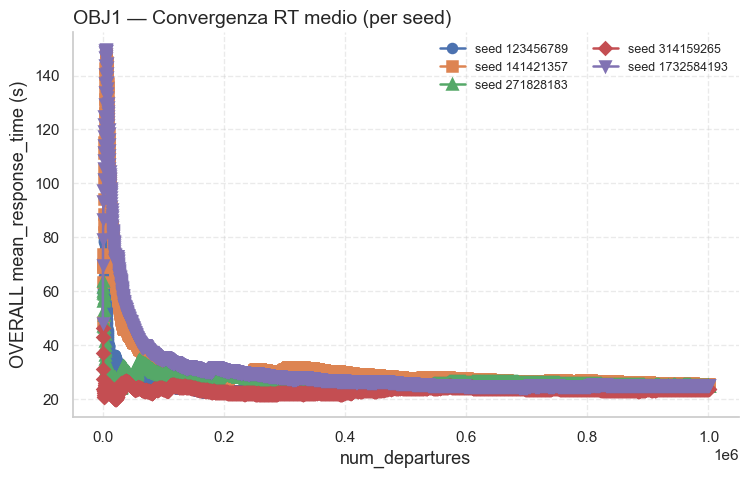

In [145]:
from typing import List, Dict
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# --- loader: lista di DF (uno per file), con seed e source ---
def load_conv_as_list(files: List[str]) -> List[pd.DataFrame]:
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # numeric coercion, ma NON toccare scope/metric
        df = _coerce_numeric(df, exclude=("scope", "metric"))
        df["seed"] = _seed_from_name(f)
        df["source"] = os.path.basename(f)
        dfs.append(df)
    return dfs  # <- LISTA di DataFrame (uno per file)

# --- estrai OVERALL/mean_response_time per seed (dict seed -> DF ordinato per num_departures) ---
def overall_mean_rt_by_seed(dfs: List[pd.DataFrame]) -> Dict[int, pd.DataFrame]:
    out: Dict[int, pd.DataFrame] = {}
    for df in dfs:
        seed = int(df["seed"].iloc[0]) if "seed" in df.columns and pd.notna(df["seed"].iloc[0]) else -1
        g = df[(df["scope"]=="OVERALL") & (df["metric"]=="mean_response_time")].copy()
        if g.empty: 
            continue
        g = g.sort_values("num_departures")
        # tieni solo ciò che serve al plot
        out[seed] = g[["num_departures", "value"]].rename(columns={"value":"mean_response_time"})
    return out

# --- plot: tutte le curve su un grafico (opzione smoothing con media mobile) ---
def plot_overall_conv_by_seed(seed_to_df: Dict[int, pd.DataFrame],
                              title=None,
                              window_ma: int | None = None,
                              marker_size: float = 0.2,
                              mark_every: int | None = 2000,
                              markers: bool = True,
                              linewidth: float = 0.2):
    fig, ax = plt.subplots(figsize=(8.6, 5.0))
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        color = f"C{i % 10}"
        ms = marker_style_for(i, color)  # hai già definito marker_style_for
        x = g["num_departures"].to_numpy()
        y = g["mean_response_time"].to_numpy(dtype=float)
        if window_ma and window_ma > 1:
            y = pd.Series(y).rolling(window_ma, min_periods=1).mean().to_numpy()
        ax.plot(x, y, linewidth=1.8, color=color, label=f"seed {seed}", **ms)
    ax.set_xlabel("num_departures")
    ax.set_ylabel("OVERALL mean_response_time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Convergenza RT medio (per seed)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(ncol=2, fontsize=9)
    plt.show()

# --- plot: una figura per seed (comodo se vuoi guardarli separati) ---
def plot_overall_conv_one_per_seed(seed_to_df: Dict[int, pd.DataFrame], window_ma: int | None = None):
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        plot_overall_conv_by_seed({seed:g},
                                  title=f"{TITLE_PREFIX} — OVERALL mean RT (seed {seed})",
                                  window_ma=window_ma)

# ====== USO ======

# 1) prendi i file conv (usa la tua utility già esistente)
conv_files = find_csv_for_config(config_file, target="conv")
print("File conv:", *conv_files, sep="\n - ")

# 2) lista di DataFrame, uno per file
dfs_conv = load_conv_as_list(conv_files)   # <<< LISTA richiesta

# 3) dict {seed -> DF OVERALL mean RT vs num_departures}
by_seed = overall_mean_rt_by_seed(dfs_conv)
print("Seeds trovati:", sorted(by_seed.keys()))

# 4a) grafico unico con tutte le curve (metti window_ma=5000 se vuoi smoothing visivo)
plot_overall_conv_by_seed(by_seed, window_ma=None)

# 4b) (opzionale) un grafico per seed
# plot_overall_conv_one_per_seed(by_seed, window_ma=10000)


In [146]:
import seaborn as sns

def _pretty_scope(s: str) -> str:
    s = str(s)
    if s == "OVERALL":
        return "OVERALL"
    if s.startswith("NODE_"):
        return f"Server {s.replace('NODE_', '')}"
    return s

def _scope_order(scopes):
    scopes = [str(s) for s in scopes]
    over = ["OVERALL"] if "OVERALL" in scopes else []
    nodes = sorted([s for s in scopes if s != "OVERALL"],
                   key=lambda x: (not x.startswith("NODE_"), x))
    return over + nodes

def _normalize_scopes(names):
    """Permette di passare 'A' o 'NODE_A' indistintamente."""
    out = []
    for n in names:
        s = str(n)
        if s == "OVERALL":
            out.append("OVERALL")
        elif s.startswith("NODE_"):
            out.append(s)
        else:
            out.append(f"NODE_{s}")
    return out





def plot_metric_vertical_by_scope(
    df: pd.DataFrame,
    metric: str,
    *,
    scopes: list[str] | None = None,    # se None: tutti
    hue: str | None = "seed",           # colorazione (se esiste la colonna)
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    # --- nuovi controlli sull'asse X ---
    xmax: float | None = None,          # se dato, usa questo come limite destro
    xlimit_scopes: list[str] | None = None,  # altrimenti usa il max di questi scope
):
    """
    Subplot verticale (una riga per scope) della metrica scelta.
    Se `xmax` non è fornito:
      - se `xlimit_scopes` è fornito, usa max(num_departures) calcolato *solo*
        su quegli scope;
      - altrimenti, se esiste NODE_A, usa il max dei NON-A (così A è troncato
        dove arrivano gli altri); altrimenti usa il max di tutti.
    """
    # --- filtro metrica
    d = df[df["metric"] == metric].copy()
    if d.empty:
        print(f"[WARN] nessun dato per metric='{metric}'")
        return

    # --- filtro scope
    all_scopes = d["scope"].dropna().unique().tolist()
    row_order = _scope_order(all_scopes) if scopes is None else _scope_order(scopes)
    d = d[d["scope"].isin(row_order)]
    if d.empty:
        print("[WARN] nessun dato dopo il filtro scope.")
        return

    # --- calcolo limite X
    if xmax is None:
        if xlimit_scopes is not None and len(xlimit_scopes) > 0:
            ref_scopes = set(_normalize_scopes(xlimit_scopes))
        else:
            # default: se c'è NODE_A e altri scope, usa max dei non-A
            nonA = [s for s in row_order if s != "NODE_A"]
            ref_scopes = set(nonA) if ("NODE_A" in row_order and nonA) else set(row_order)
        xmax = float(d[d["scope"].isin(ref_scopes)]["num_departures"].max())

    xmin = float(d["num_departures"].min())

    # --- estetica seaborn
    sns.set_theme(style="whitegrid", context="notebook")
    use_hue = hue if (hue is not None and hue in d.columns) else None

    g = sns.relplot(
        data=d, kind="line",
        x="num_departures", y="value",
        row="scope", row_order=row_order,
        hue=use_hue, palette=palette,
        markers=markers, dashes=False,
        linewidth=linewidth, alpha=alpha,
        facet_kws=dict(sharex=True, sharey=False, margin_titles=False),
        height=height, aspect=aspect,
        estimator=None, errorbar=None, sort=True,
    )

    # titoli/assi + xlim comune
    for ax, scope in zip(g.axes.flat, row_order):
        ax.set_title(_pretty_scope(scope))
        ax.set_xlabel("num_departures")
        ax.set_ylabel(metric)
        ax.set_xlim(xmin, xmax)
        ax.grid(True, linestyle="--", alpha=0.35)

    suptitle = f"{TITLE_PREFIX} — Convergenza per scope — metrica: {metric}"
    g.figure.suptitle(suptitle, y=1.02, fontsize=14, weight="bold")

    if use_hue is not None and g._legend is not None:
        g._legend.set_title(use_hue)

    plt.tight_layout()
    plt.show()


In [147]:
import seaborn as sns
from typing import List


def _stack_conv_frames(frames: list[pd.DataFrame],
                       seeds: list[int] | None = None) -> pd.DataFrame:
    kept_cols = ["scope", "metric", "value", "num_departures", "seed", "source"]
    buf = []
    for i, df in enumerate(frames):
        d = df.copy()
        d = _coerce_numeric(d, exclude=("scope", "metric"))
        if "seed" not in d.columns or d["seed"].isna().all():
            cand = None
            if "source" in d.columns and isinstance(d["source"].iloc[0], str):
                cand = _seed_from_name(d["source"].iloc[0])
            d["seed"] = cand if cand is not None else i
        d = d[[c for c in kept_cols if c in d.columns]]
        buf.append(d)
    big = pd.concat(buf, ignore_index=True)
    if seeds is not None:
        big = big[big["seed"].isin(seeds)]
    return big

def plot_metric_vertical_by_scope_from_list(
    dfs: List[pd.DataFrame],
    metric: str,
    *,
    scopes: list[str] | None = None,   # se None: tutti gli scope presenti
    seeds: list[int] | None = None,    # opzionale: filtra i seed
    hue: str | None = "seed",          # colorazione (se esiste la colonna)
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    # passa-through per il controllo dell'asse X
    xmax: float | None = None,
    xlimit_scopes: list[str] | None = None,
):
    """
    Wrapper che accetta una LISTA di DataFrame (uno per seed/file) e delega
    a `plot_metric_vertical_by_scope`, ereditandone anche `xmax` e `xlimit_scopes`.
    """
    d = _stack_conv_frames(dfs, seeds=seeds)
    return plot_metric_vertical_by_scope(
        d, metric,
        scopes=scopes,
        hue=hue,
        height=height,
        aspect=aspect,
        markers=markers,
        linewidth=linewidth,
        alpha=alpha,
        palette=palette,
        xmax=xmax,
        xlimit_scopes=xlimit_scopes,
    )


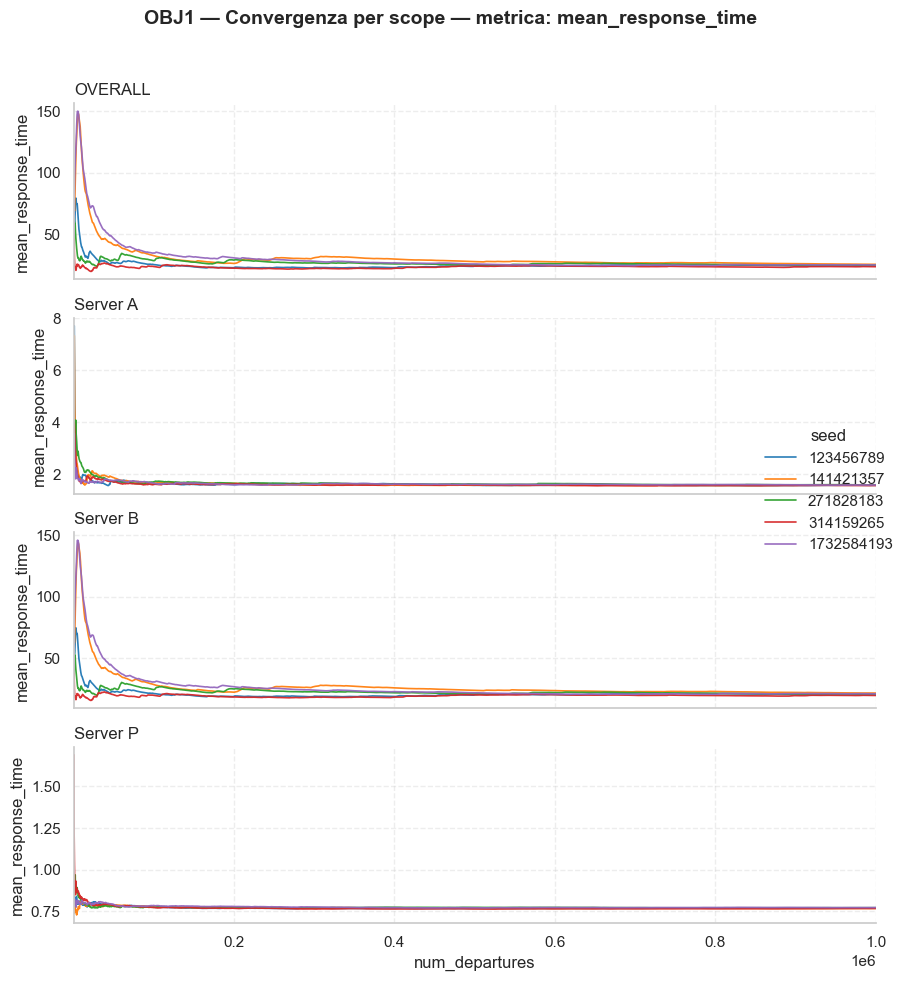

In [148]:


# 2) li carico come LISTA di DF (uno per file/seed)
dfs_conv = load_conv_as_list(conv_files)

plot_metric_vertical_by_scope_from_list(
    dfs_conv, "mean_response_time",
    xlimit_scopes=["OVERALL", "B", "P"]   # 'B' == 'NODE_B', normalizzato
)
